# Support Vector Machines (SVM) Implementation From Scratch on RDD

In [0]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql import SQLContext
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, max, udf
from functools import reduce 
from pyspark.sql import DataFrame
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, OneHotEncoder, PCA
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.types import FloatType, DoubleType, StructType, StructField, StringType, IntegerType
from pyspark.ml.feature import Imputer
from graphframes import *
from joblibspark import register_spark
from joblib import Parallel, delayed

from sparkdl.xgboost import XgboostClassifier
from pyspark.ml.linalg import DenseVector

spark.sparkContext.addPyFile("dbfs:/custom_cv.py")
from custom_cv import CustomCrossValidator
 
sqlContext = SQLContext(sc)

In [0]:
# Configuration for Blob Storage 

blob_container = "container1" # The name of your container created in https://portal.azure.com
storage_account = "w261sp22team12" # The name of your Storage account created in https://portal.azure.com
secret_scope = "s1" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "k1" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

In [0]:
# SAS Token
spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

In [0]:
# Set partitions
spark.conf.set("spark.sql.shuffle.partitions", 1000)
spark.conf.set("spark.sql.files.minPartitionNum", 1000)

In [0]:
spark

Out[23]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.2 
 Master 
 spark://10.139.64.4:7077 
 AppName 
 Databricks Shell

In [0]:
def sparkShape(dataFrame):
    return (dataFrame.count(), len(dataFrame.columns))

In [0]:
def mergeDataframes(*dfs):
    return reduce(DataFrame.unionAll, dfs)

In [0]:
pd.set_option('display.max_columns', None)

## Data

In [0]:
'''
Create toy dataset
- select a random date: August 20, 2016 

'''

# df = spark.read.parquet(f"{blob_url}/df3") \
#                 .repartition(1000, 'fl_date') \
#                 .filter(col('year') == 2016) \
#                 .filter(col('month') == 8) \
#                 .filter(col('day_of_month') == 20) \
#                 .orderBy(asc("fl_tz")) \
#                 .persist()

# Quarter 1 of 2015
df = spark.read.parquet(f"{blob_url}/df3") \
                .repartition(1000, 'fl_date') \
                .filter(col('year') == 2015) \
                .filter(col('quarter') == 1) \
                .orderBy(asc("fl_tz")) \
                .persist()

# Create a tempview for quick sql query
df.createOrReplaceTempView('df')

In [0]:
print(sparkShape(df))

(465869, 61)

In [0]:
df = df.orderBy(asc("fl_tz")) \
        .drop('features') \
        .withColumn('svm_label', when(col('label') == 0.0, -1.0).otherwise(1.0)) \
        .persist()

df_train = df.filter(col('month') <= 2).persist() 

df_holdout = df.filter(col('month') == 3).persist()

In [0]:
print(sparkShape(df_train), sparkShape(df_holdout))

(298912, 61) (166957, 61)

In [0]:
display(df_train)

label,fl_tz,origin_icao,dest_icao,tail_num,fl_date,op_unique_carrier,op_carrier_airline_id,op_carrier_fl_num,year,quarter,month,day_of_month,day_of_week,dwnd_blk,dep_del15,dep_delay_new,distance,airport_total_flights_pwnd,airport_delayed_flights_pwnd,airport_delayed_mins_pwnd,airport_pct_flight_delayed,airline_total_flights_pwnd,airline_delayed_flights_pwnd,airline_delayed_mins_pwnd,airline_pct_flight_delayed,ripple_effect_delay,timediff_prev_flight,avg_wind_directional_angle,avg_wind_directional_speed_rate,avg_sky_ceiling_height_dimension,avg_vis_distance,avg_air_temperature,avg_dew_point_temperature,avg_sea_level_pressure,avg_lp_period_qty,avg_ap_altimeter_setting_rate,avg_sky_height_dimension,min_wind_directional_angle,min_wind_directional_speed_rate,min_sky_ceiling_height_dimension,min_vis_distance,min_air_temperature,min_dew_point_temperature,min_sea_level_pressure,min_lp_period_qty,min_ap_altimeter_setting_rate,min_sky_height_dimension,max_wind_directional_angle,max_wind_directional_speed_rate,max_sky_ceiling_height_dimension,max_vis_distance,max_air_temperature,max_dew_point_temperature,max_sea_level_pressure,max_lp_period_qty,max_ap_altimeter_setting_rate,max_sky_height_dimension,airport_pagerank,cv,svm_label
0.0,2015-01-01T07:00:00.000+0000,KIAG,KFLL,N630NK,2015-01-01,NK,20416,647,2015,1,1,1,4,0200-0259,0.0,0.0,1176.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,265.0,92.5,3505.5,16093.0,-64.0,-144.5,10176.5,1.0,10161.0,2286.0,260.0,82.0,3353.0,16093.0,-67.0,-156.0,10170.0,1.0,10159.0,1219.0,270.0,103.0,3658.0,16093.0,-61.0,-133.0,10183.0,1.0,10163.0,3353.0,0.3105757860764766,train,-1.0
0.0,2015-01-01T07:40:00.000+0000,KSLC,KATL,N3751B,2015-01-01,DL,19790,2324,2015,1,1,1,4,0000-0059,0.0,0.0,1590.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.33929635766117,0.0,22000.0,16093.0,-106.0,-167.0,10258.0,1.0,10207.0,2707.923570122724,196.86434051302243,0.0,22000.0,16093.0,-106.0,-167.0,10258.0,1.0,10207.0,2669.181531849276,212.3041716563592,0.0,22000.0,16093.0,-106.0,-167.0,10258.0,1.0,10207.0,2741.984229837541,6.628675172607871,train,-1.0
1.0,2015-01-01T08:20:00.000+0000,KDEN,KMIA,N3HRAA,2015-01-01,AA,19805,2392,2015,1,1,1,4,0100-0159,1.0,21.0,1709.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190.0,52.8,22000.0,16093.0,-149.4,-214.6,10267.0,1.0,10197.6,2975.191440025926,190.0,36.0,22000.0,16093.0,-167.0,-233.0,10267.0,1.0,10193.0,2672.197910754824,190.0,57.0,22000.0,16093.0,-140.0,-210.0,10267.0,1.0,10203.0,3273.916645552943,10.152850223650066,train,1.0
1.0,2015-01-01T08:25:00.000+0000,KPHX,KORD,N629NK,2015-01-01,NK,20416,168,2015,1,1,1,4,0100-0159,1.0,72.0,1440.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,265.0,36.0,884.0,16093.0,30.5,3.0,10157.0,1.0,10157.5,518.5,250.0,26.0,732.0,16093.0,28.0,0.0,10156.0,1.0,10156.0,305.0,280.0,46.0,1036.0,16093.0,33.0,6.0,10158.0,1.0,10159.0,732.0,5.185500125927081,train,1.0
0.0,2015-01-01T08:25:00.000+0000,KSFO,KMSP,N3730B,2015-01-01,DL,19790,806,2015,1,1,1,4,0000-0059,0.0,0.0,1589.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,21.0,22000.0,16093.0,72.0,22.0,10187.0,1.0,10186.0,1431.3895448714168,150.0,21.0,22000.0,16093.0,72.0,22.0,10187.0,1.0,10186.0,1419.760178276513,150.0,21.0,22000.0,16093.0,72.0,22.0,10187.0,1.0,10186.0,1442.9292349887933,5.04555447243195,train,-1.0
0.0,2015-01-01T08:27:00.000+0000,KPHX,KMIA,N3CGAA,2015-01-01,AA,19805,2211,2015,1,1,1,4,0100-0159,0.0,0.0,1972.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,265.0,36.0,884.0,16093.0,30.5,3.0,10157.0,1.0,10157.5,518.5,250.0,26.0,732.0,16093.0,28.0,0.0,10156.0,1.0,10156.0,305.0,280.0,46.0,1036.0,16093.0,33.0,6.0,10158.0,1.0,10159.0,732.0,5.185500125927081,train,-1.0
0.0,2015-01-01T08:30:00.000+0000,KLAX,KCLT,N584UW,2015-01-01,US,20355,2013,2015,1,1,1,4,0000-0059,0.0,14.0,2125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200.1665577909452,0.0,22000.0,16093.0,86.0,-86.0,10180.0,1.0,10181.0,7620.0,193.0747846706821,0.0,22000.0,16093.0,83.0,-100.0,10179.0,1.0,10179.0,7620.0,209.07344362875585,0.0,22000.0,16093.0,89.0,-72.0,10181.0,1.0,10183.0

In [0]:
# Using only airlines data

## 7 one-hot encoded features
ohe_features = [
    'quarter',
    'month',
    'day_of_month',
    'day_of_week',
    'op_carrier_airline_id',
    'dwnd_blk'
]

## 14 airline features
airline_features = [   
    'distance',
    
    'airport_total_flights_pwnd',
    'airport_delayed_flights_pwnd',
    'airport_delayed_mins_pwnd',
    'airport_pct_flight_delayed',
    
    'airline_total_flights_pwnd',
    'airline_delayed_flights_pwnd',
    'airline_delayed_mins_pwnd',
    'airline_pct_flight_delayed',
    
    'ripple_effect_delay',
    'timediff_prev_flight'
]

## 39 weather features
weather_features = [
    'avg_wind_directional_angle',
    'avg_wind_directional_speed_rate',
    'avg_sky_ceiling_height_dimension',
    'avg_vis_distance',
    'avg_air_temperature',
    'avg_dew_point_temperature',
    'avg_sea_level_pressure',
    'avg_lp_period_qty',
    'avg_ap_altimeter_setting_rate',
    'avg_sky_height_dimension',
]

features = airline_features.copy()
features.extend(weather_features)
print(features)

label='label'

['distance', 'airport_total_flights_pwnd', 'airport_delayed_flights_pwnd', 'airport_delayed_mins_pwnd', 'airport_pct_flight_delayed', 'airline_total_flights_pwnd', 'airline_delayed_flights_pwnd', 'airline_delayed_mins_pwnd', 'airline_pct_flight_delayed', 'ripple_effect_delay', 'timediff_prev_flight', 'avg_wind_directional_angle', 'avg_wind_directional_speed_rate', 'avg_sky_ceiling_height_dimension', 'avg_vis_distance', 'avg_air_temperature', 'avg_dew_point_temperature', 'avg_sea_level_pressure', 'avg_lp_period_qty', 'avg_ap_altimeter_setting_rate', 'avg_sky_height_dimension']

In [0]:
def train_sample(df, downsample=True, verbose=True):
    on_time_df = df.filter(col('label') == 0).persist()
    on_time_count = on_time_df.count()
    
    delayed_df = df.filter(col('label') == 1).persist()
    delayed_count = delayed_df.count()
    
    on_time_keep_percent = delayed_count*1.0 / on_time_count
    delayed_keep_percent = on_time_count*1.0 / delayed_count
    
    if verbose:
        print('delayed count:', delayed_count, 'on_time_count:', on_time_count, 'on_time_keep_percent', on_time_keep_percent, 'delayed_keep_percent', delayed_keep_percent)
    
    if downsample:
        if on_time_keep_percent < 1.0:
            # downsample ontime flights
            if verbose:
                print('Downsampling on time flights')
            sdf = mergeDataframes(*[delayed_df,
                                    on_time_df.sample(withReplacement=False, fraction=on_time_keep_percent, seed=2)
                                    ]).persist()

            return sdf

        if delayed_keep_percent < 1.0:
            # downsample delayed flights
            if verbose:
                print('Downsampling delayed flights')
            sdf = mergeDataframes(*[delayed_df.sample(withReplacement=False, fraction=delayed_keep_percent, seed=2),
                                    on_time_df,
                                    ]).persist()
            return sdf

    if verbose:
        print('No downsampling')
    return df

In [0]:
def pipeline_fit(df, ohe_features, features):
    stages = []
    
    c_columns_str =  [f'{ohe_feature}_str' for ohe_feature in ohe_features]
    ohe_indexer = StringIndexer(inputCols=ohe_features, outputCols= c_columns_str).setHandleInvalid("keep")
    stages += [ohe_indexer]
    
    c_columns_ohe = [f'{ohe_feature}_ohe' for ohe_feature in ohe_features]
    ohe_encoder = OneHotEncoder(inputCols=c_columns_str, outputCols=c_columns_ohe)
    stages += [ohe_encoder]

    pfeatures = features.copy()
    pfeatures.extend(c_columns_ohe)
    
    assembler = VectorAssembler(inputCols=pfeatures, outputCol='vectorized_features')
    assembler.setHandleInvalid("skip")
    stages += [assembler]
    
    scaler = StandardScaler(inputCol='vectorized_features', outputCol='features')
    stages += [scaler]

    pipeline = Pipeline(stages = stages)
    pipelineModel = pipeline.fit(df)
    return pipelineModel

In [0]:
def pipeline_transform(model, df):
    xdf = df.drop('features')
    transformed_df = model.transform(xdf).select('label', 'svm_label', 'features')
    return transformed_df.rdd.map(lambda row: (row[0], row[1], DenseVector(row[2].toArray()).toArray()))

In [0]:
df_train_sample = train_sample(df_train)
print(sparkShape(df_train_sample))

pipeline_model = pipeline_fit(df_train_sample, ohe_features, features)

delayed count: 165270 on_time_count: 133642 on_time_keep_percent 1.2366621271755884 delayed_keep_percent 0.8086283051975555
Downsampling delayed flights
(267206, 61)

In [0]:
rdd_train_tx = pipeline_transform(pipeline_model, df_train_sample).cache()
rdd_train = pipeline_transform(pipeline_model, df_train).cache()
rdd_holdout_tx = pipeline_transform(pipeline_model, df_holdout).cache()

In [0]:
sample = rdd_train_tx.take(1)

In [0]:
print(sample)
print(len(sample[0][2]))

[(1.0, 1.0, array([ 3.03301593, 0. , 0. , 0. ,
 0. , 0. , 0. , 0. ,
 0. , 0. , 0. , 1.93936551,
 2.08223571, 2.31442797, 2.97106308, -1.37670462,
 -2.01360202, 135.53271677, 2.26019997, 25.03641236,
 1.2472315 , 0. , 2.00119155, 0. ,
 0. , 0. , 0. , 0. ,
 0. , 0. , 0. , 0. ,
 0. , 0. , 0. , 0. ,
 0. , 0. , 0. , 0. ,
 0. , 0. , 0. , 0. ,
 0. , 0. , 0. , 0. ,
 0. , 5.99385717, 0. , 0. ,
 0. , 0. , 0. , 0. ,
 2.71490591, 0. , 0. , 0. ,
 0. , 0. , 0. , 0. ,
 0. , 0. , 3.44994555, 0. ,
 0. , 0. , 0. , 0. ,
 0. , 0. , 0. , 0. ,
 0. , 0. , 0. , 0. ,
 0. , 0. , 0. , 0. ,
 0. , 0. , 0. , 0. ,
 0. , 0. , 0. , 0. ,
 0. , 0. , 31.13093459, 0. ]))]
96

## SVM

In [0]:
def hingeLoss(dataRDD, W):
    """
    Perform one OLS gradient descent step/update.
    Args:
        dataRDD - records are tuples of (y, features_array)
        W       - (array) model coefficients
    Returns:
        loss - hingeLoss of the current model for the data
    """
    
    # add bias term
    augmentedData = dataRDD.map(lambda x: (x[1], np.append([1.0], x[2])))

    # broadcast the current weights / model
    W_broadcast = sc.broadcast(W)
    
    
    def loss(row):
        y, X = row[0], row[1]
        z = y * np.dot(W_broadcast.value, X)
        hl = np.maximum(0, 1-z)
        return hl
    
    hinge = augmentedData.map(loss).mean()
    
    return hinge

In [0]:
  def GDUpdate(dataRDD, W, learningRate = 0.01, regParam = 0.1):
    """
    Perform one OLS gradient descent step/update.
    Args:
        dataRDD - records are tuples of (y, features_array)
        W       - (array) model coefficients
    Returns:
        update - update to the model
    """
    
    # add bias term
    augmentedData = dataRDD.map(lambda x: (x[1], np.append([1.0], x[2])))

    # broadcast the current weights / model
    W_broadcast = sc.broadcast(W)
    
    # spark job to compute the gradient
    
    def gradient(row):
        y, X = row[0], row[1]
        grad = 0.0
        # add gradient only for misclassified
        if y*np.dot(X, W_broadcast.value) < 1:
            grad = -1 * y * X
        return grad
        
    g = augmentedData.map(gradient).mean()
    
    Wreg = W * 1
    # do not regularize bias term
    Wreg[0] = 0
    
    update = learningRate * (g + regParam * Wreg)
    
    return update

In [0]:
def train_model(rdd, lr=0.01, reg=0.1, maxIter=1000, computeLoss=True, verbose=False):
    s = rdd.take(1)
    nfeatures = len(s[0][2])
    ymean = rdd.map(lambda x: x[1]).mean() 
    if verbose:
        print('number of features:', nfeatures)
        print('bias initial value:', ymean)
    model = np.append([ymean], np.array([0.0]*(nfeatures), dtype=np.float64))
    for idx in range(maxIter):
        update = GDUpdate(rdd, model, learningRate=lr, regParam=reg)
        model = model - update
        if computeLoss:
            hloss = hingeLoss(rdd, model)
            if verbose:
                print(f'Step {idx+1}: loss: {hloss}')
        else:
            if verbose:
                print(f'Step {idx+1}')
    return model

In [0]:
svm_model = train_model(rdd_train_tx, lr=0.001, reg=0.01, maxIter=10, computeLoss=True, verbose=True)

number of features: 96
bias initial value: -0.00029190961280766434
Step 1: loss: 0.999516387370163
Step 2: loss: 0.9990328647868225
Step 3: loss: 0.9985493470387058
Step 4: loss: 0.9980658341257661
Step 5: loss: 0.9975823260479554
Step 6: loss: 0.9970988228052253
Step 7: loss: 0.9966153243975239
Step 8: loss: 0.996131830824809
Step 9: loss: 0.995648342087027
Step 10: loss: 0.9951648581841326

In [0]:
print(svm_model)

[-2.94828709e-04 2.07600941e-04 1.01237471e-03 2.26047385e-03
 2.18114903e-03 2.77038087e-03 4.19472609e-04 1.78186548e-03
 1.90618968e-03 2.42068821e-03 8.76392003e-04 1.02178626e-03
 1.70715814e-04 1.08741397e-03 -1.03061221e-03 -7.50033383e-04
 -7.69031656e-04 -6.15822270e-04 -2.29258202e-04 1.06426874e-05
 9.06358343e-07 -9.05848123e-04 0.00000000e+00 -3.66211326e-04
 3.60369918e-04 6.71155368e-04 5.05187531e-04 5.50182072e-04
 2.35990405e-04 3.24344771e-04 1.66763866e-04 2.80585824e-04
 1.29807592e-04 1.47316141e-04 6.77327356e-05 -2.37041403e-04
 -9.99100353e-05 -1.70744880e-04 -1.75475406e-04 -4.05821758e-05
 -1.24506110e-04 7.64379426e-05 -2.46821446e-04 -1.48465132e-04
 -2.20590029e-04 -1.18582935e-04 -2.49217110e-05 -1.31937597e-04
 -2.66133540e-04 -3.44622433e-04 -6.50487025e-06 -3.76827136e-04
 -2.61758863e-04 -7.13460351e-05 -3.92344863e-04 -3.99791944e-04
 -1.35078543e-04 -1.25982644e-05 4.96443567e-04 -6.56459571e-06
 -4.12141407e-04 3.05927614e-04 -2.60732893e-04 -8.94824136e-05
 -5.74817546e-04 -9.54287382e-05 7.92392098e-05 -1.54023481e-04
 4.48845840e-04 6.76137800e-04 -4.02128225e-04 3.43885523e-04
 2.15686457e-04 -4.42564961e-04 3.47445996e-04 -1.07371388e-04
 -1.49304068e-04 5.04101440e-04 1.72625740e-04 3.58510149e-04
 4.59702088e-04 -4.64007186e-05 6.07909687e-04 2.90025800e-04
 -1.61133033e-04 5.23866876e-05 -6.92125382e-04 -4.11535526e-04
 6.35774833e-04 -1.30598780e-03 -9.86177756e-04 5.24063433e-04
 2.71924330e-04 -5.27866367e-04 -9.22036948e-05 -4.19400468e-05
 -3.05885615e-05]

In [0]:
def metrics(predictionAndLabels):
    bcm = BinaryClassificationMetrics(predictionAndLabels)
    mcm = MulticlassMetrics(predictionAndLabels)
    d = [
        bcm.areaUnderROC, 
        bcm.areaUnderPR, 
        mcm.fMeasure(label=1.0), 
        mcm.recall(label=1),
        mcm.precision(label=1), 
        mcm.accuracy            
    ]

    return d

def predict_labels(rdd, model):
    model_broadcast = sc.broadcast(model)

    def predict(row):
        expected = row[1]
        data = row[2]
        predicted = np.sign(np.dot(np.append([1.0], data), model_broadcast.value))
        return (float(predicted), float(expected))
        
    result = rdd.map(predict)
    
    return result

In [0]:
def plotConfusionMatrix(train_predictionAndLabels, test_predictionAndLabels):
    train_mcm = MulticlassMetrics(train_predictionAndLabels)
    test_mcm = MulticlassMetrics(test_predictionAndLabels)

    train_cm = train_mcm.confusionMatrix().toArray()
    test_cm = test_mcm.confusionMatrix().toArray()
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

    trainMatrix = pd.DataFrame(train_cm)
    sns.heatmap(trainMatrix, annot=True, cmap='Blues', fmt=',', ax=axes[0])
    axes[0].set_title('Confusion Matrix on Training Set')
    axes[0].set_ylabel('Actual')
    axes[0].set_xlabel('Predicted')

    testMatrix = pd.DataFrame(test_cm)
    sns.heatmap(testMatrix, annot=True, cmap='Blues', fmt=',', ax=axes[1])
    axes[1].set_title('Confusion Matrix on Test Set')
    axes[1].set_ylabel('Actual')
    axes[1].set_xlabel('Predicted')
    
    plt.show()

In [0]:
native_train_results = predict_labels(rdd_train_tx, svm_model)
native_test_results = predict_labels(rdd_holdout_tx, svm_model)

In [0]:
print(native_train_results.take(10))

[(-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0)]

In [0]:
results = []
results.append(metrics(native_train_results))
results.append(metrics(native_test_results))

columns = ['Area Under ROC', 'Area Under PR', 'F1 score', 'Recall', 'Precision', 'Accuracy']
results_df = pd.DataFrame(results, columns=columns)
results_df.index = ['Training (Native)', 'Test (Native)']
print(results_df.T)

Training (Native) Test (Native)
Area Under ROC 0.551794 0.535170
Area Under PR 0.700970 0.705048
F1 score 0.216960 0.157036
Recall 0.124188 0.086448
Precision 0.857653 0.855998
Accuracy 0.551919 0.512258

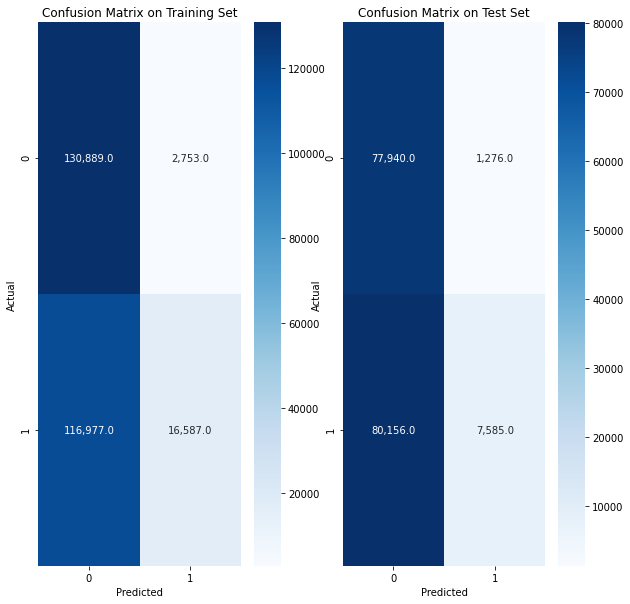

In [0]:
plotConfusionMatrix(native_train_results, native_test_results)

## Cross Validation for Finding the Best Learning Rate

In [0]:
cuts = [
    ('2015-02-16', '2015-03-01')
]

def cv_sample(splits):
    split_dfs = []
    for split in splits:
        train_split, val_split = split
        train_df = df_train.filter(col('fl_date') < train_split).persist()
        val_df = df_train.filter((col('fl_date') >= train_split) & (col('fl_date') < val_split)).persist()
        print(split, sparkShape(train_df), sparkShape(val_df))
        split_dfs.append((train_df, val_df))
    return split_dfs

In [0]:
def train_eval_split(split, split_df, lr, maxIter=1000, verbose=False):
    train_df, val_df = split_df
    train_sample_df = train_sample(train_df, downsample=True, verbose=verbose)
    print(sparkShape(train_sample_df))
    pipeline_split_model = pipeline_fit(train_sample_df, ohe_features, features)
    train_sample_rdd = pipeline_transform(pipeline_split_model, train_sample_df).cache()
    val_rdd = pipeline_transform(pipeline_split_model, val_df).cache()
    mdl = train_model(train_sample_rdd, lr=lr, reg=0.01, maxIter=maxIter, computeLoss=False, verbose=verbose)
    val_results = predict_labels(val_rdd, mdl)
    return metrics(val_results)

In [0]:
def cross_validate(rates, splits, dfs):
    best = None
    bestLR = None
    for rate in rates:
        for index, split in enumerate(splits):
            print(f'cross-validating: ({rate}, {split})')
            val_metrics = train_eval_split(split, dfs[index], rate, maxIter=10, verbose=False)
            print(f'metrics: {val_metrics}')
            areaPR = val_metrics[1]
            if best is None or areaPR > best:
                best = areaPR
                bestLR = rate
            print(f'current best LR: {bestLR}, areaUnderPR {best}')
    return bestLR

In [0]:
cut_dfs = cv_sample(cuts)
learning_rate = cross_validate([0.01, 0.001, 0.0001], cuts, cut_dfs)
print(f'Best learning rate from cross validation for SVM classifier: {learning_rate}')

('2015-02-16', '2015-03-01') (224387, 61) (74525, 61)
cross-validating: (0.01, ('2015-02-16', '2015-03-01'))
(212082, 61)
metrics: [0.5019664385244724, 0.6307876211305596, 0.7734522465195638, 0.9995100232206386, 0.6307878461952138, 0.6311975847031197]
current best LR: 0.01, areaUnderPR 0.6307876211305596
cross-validating: (0.001, ('2015-02-16', '2015-03-01'))
(212082, 61)
metrics: [0.5, 0.6298691714189869, 0.772907644937678, 1.0, 0.6298691714189869, 0.6298691714189869]
current best LR: 0.01, areaUnderPR 0.6307876211305596
cross-validating: (0.0001, ('2015-02-16', '2015-03-01'))
(212082, 61)
metrics: [0.5, 0.6298691714189869, 0.772907644937678, 1.0, 0.6298691714189869, 0.6298691714189869]
current best LR: 0.01, areaUnderPR 0.6307876211305596
Best learning rate from cross validation for SVM classifier: 0.01

### Best SVM Model

In [0]:
best_svm_model = train_model(rdd_train_tx, lr=learning_rate, reg=0.01, maxIter=10, verbose=False)

In [0]:
print(best_svm_model)

[-3.21212847e-04 2.06183215e-03 1.00920152e-02 2.25226878e-02
 2.18031422e-02 2.76738469e-02 4.32160836e-03 1.78548248e-02
 1.91030487e-02 2.42465000e-02 8.77717096e-03 1.01315388e-02
 1.66119145e-03 1.07109593e-02 -1.03150120e-02 -7.46686561e-03
 -7.66913733e-03 -6.14585822e-03 -2.21517023e-03 4.21656979e-05
 -5.84111300e-05 -8.97054422e-03 0.00000000e+00 -3.66063047e-03
 3.60201537e-03 6.70883618e-03 5.04982981e-03 5.49959303e-03
 2.35894853e-03 3.24154185e-03 1.66696344e-03 2.80472215e-03
 1.29755033e-03 1.47256493e-03 6.77053106e-04 -2.36945425e-03
 -9.98695818e-04 -1.70675746e-03 -1.75404356e-03 -4.05657441e-04
 -1.24455698e-03 7.64069929e-04 -2.46721508e-03 -1.48405019e-03
 -2.20500713e-03 -1.18534921e-03 -2.49116202e-04 -1.31884175e-03
 -2.66025783e-03 -3.44482896e-03 -6.50223644e-05 -3.76674559e-03
 -2.61652877e-03 -7.13171471e-04 -3.92186003e-03 -3.99630068e-03
 -1.35023850e-03 -1.25931634e-04 4.96210916e-03 -6.56193771e-05
 -4.11974531e-03 3.05803744e-03 -2.60627323e-03 -6.96187976e-04
 -5.73381599e-03 -9.47931648e-04 7.20956502e-04 -1.61575288e-03
 4.54214320e-03 6.73551904e-03 -4.09216189e-03 3.32469565e-03
 2.10825713e-03 -4.43829585e-03 3.41727292e-03 -1.05404474e-03
 -1.43503476e-03 5.09422264e-03 1.61033154e-03 3.54479103e-03
 4.60397661e-03 -4.12283831e-04 6.03825981e-03 2.97055571e-03
 -1.70365931e-03 5.62666292e-04 -6.95780379e-03 -4.02919325e-03
 6.37266830e-03 -1.29971230e-02 -9.93092555e-03 5.20484333e-03
 2.81199579e-03 -5.27290733e-03 -9.21663616e-04 -4.30875949e-04
 -2.75185586e-04]

In [0]:
best_svm_train_results = predict_labels(rdd_train_tx, best_svm_model)
best_svm_test_results = predict_labels(rdd_holdout_tx, best_svm_model)

In [0]:
results = []
results.append(metrics(best_svm_train_results))
results.append(metrics(best_svm_test_results))

columns = ['Area Under ROC', 'Area Under PR', 'F1 score', 'Recall', 'Precision', 'Accuracy']
results_df = pd.DataFrame(results, columns=columns)
results_df.index = ['Training (Native)', 'Test (Native)']
print(results_df.T)

Training (Native) Test (Native)
Area Under ROC 0.555052 0.538238
Area Under PR 0.698822 0.703687
F1 score 0.230749 0.170727
Recall 0.133472 0.094882
Precision 0.850931 0.850966
Accuracy 0.555175 0.515600

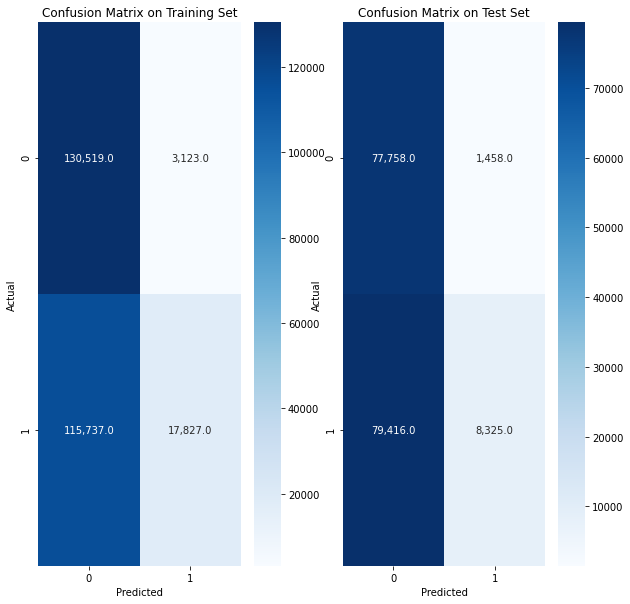

In [0]:
plotConfusionMatrix(best_svm_train_results, best_svm_test_results)

## SVM from MLLib

In [0]:
from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint

In [0]:
def constructRdd(rdd):
    # Load and parse the data
    def parse(line):
        y = line[0]
        X = line[2]
        return LabeledPoint(float(y), np.append([1.0], X))
    
    return rdd.map(parse)

def mllibSVM(rdd): 
    # Build the model
    mappedRdd = constructRdd(rdd)
    model = SVMWithSGD.train(mappedRdd, iterations=10, regParam=0.01, intercept=True)
    
    return model

In [0]:
mllib_svm_model = mllibSVM(rdd_train_tx)

In [0]:
print(mllib_svm_model)

(weights=[-0.06474994846656189,-0.04066487357823259,0.18934227391448208,0.5144502289439287,0.4975841116369776,0.6278787382033615,0.06732099793359839,0.4097732583909981,0.44276801197113325,0.5587342820460764,0.20610383020878648,0.23577678199071347,-0.09381016968677872,0.1659868262967042,-0.33034856247626276,-0.352680197474549,-0.2143311690118861,-0.1345477833835805,-8.68600384022633,-0.1467286012867241,-1.60675189102543,-0.28409488754380086,0.0,-0.15621305784867062,0.026636007839367704,0.15105773691104923,0.11053846303451183,0.12204284488397946,0.04495700651292773,0.06704576652175043,0.028353822163406223,0.056323899732217034,0.019402161247347442,0.023752709954945196,0.0043443312901643265,-0.07042462400841187,-0.03668477973288926,-0.054068280031792995,-0.055227882537113,-0.02187824936448336,-0.042374639894177724,0.007075655952875348,-0.07223292624332545,-0.04805990941989402,-0.06575763598034629,-0.04054586669058741,-0.017528341742615562,-0.0436713643815685,-0.07652310221278595,-0.0956746141076169,-0.012595603905298437,-0.10347042708289739,-0.07512677714615609,-0.026278965625600306,-0.10435322113474081,-0.10513596895597367,-0.06145155817843801,-0.03123467294736728,0.09524964311204498,-0.026940753386725635,-0.12637923033614623,0.04997075905944122,-0.08815548726205932,-0.05077860161877283,-0.16618896016577478,-0.045842980241186285,-0.004043377289603925,-0.060098518922488735,0.09109704379459485,0.14761458773831587,-0.11745289986617807,0.0674368619130555,0.04260264265338491,-0.11746172706996662,0.07568906008712085,-0.03219279302936373,-0.03737872719734795,0.10588183666611665,0.02143538253772416,0.06915559920592645,0.0955759789938686,-0.027641082679657137,0.13093023627558215,0.055674537322925016,-0.058905441823567425,-0.0033053245329258477,-0.18783357537818446,-0.1153359266714766,0.14053894880171572,-0.33526062901901355,-0.25953107014884674,0.11532498111898748,0.06231128661169043,-0.13622829069358447,-0.025009958444153595,-0.012636520020116039,-0.007563346151799759], intercept=0.8861398560553075)

In [0]:
def mlllib_svm_predict(rdd, model):
    mappedRdd = constructRdd(rdd)
    return mappedRdd.map(lambda p: (float(model.predict(p.features)), float(p.label)))

In [0]:
mllib_train_results = mlllib_svm_predict(rdd_train_tx, mllib_svm_model)
mllib_test_results = mlllib_svm_predict(rdd_holdout_tx, mllib_svm_model)

In [0]:
print(mllib_train_results.take(10))

[(0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]

In [0]:
mllib_results = []
mllib_results.append(metrics(mllib_train_results))
mllib_results.append(metrics(mllib_test_results))

columns = ['Area Under ROC', 'Area Under PR', 'F1 score', 'Recall', 'Precision', 'Accuracy']
mllib_results_df = pd.DataFrame(mllib_results, columns=columns)
mllib_results_df.index = ['Training (MLLib)', 'Test (MLLib)']
print(mllib_results_df.T)

Training (MLLib) Test (MLLib)
Area Under ROC 0.500000 0.500000
Area Under PR 0.499854 0.525531
F1 score 0.000000 0.000000
Recall 0.000000 0.000000
Precision 0.000000 0.000000
Accuracy 0.500146 0.474469

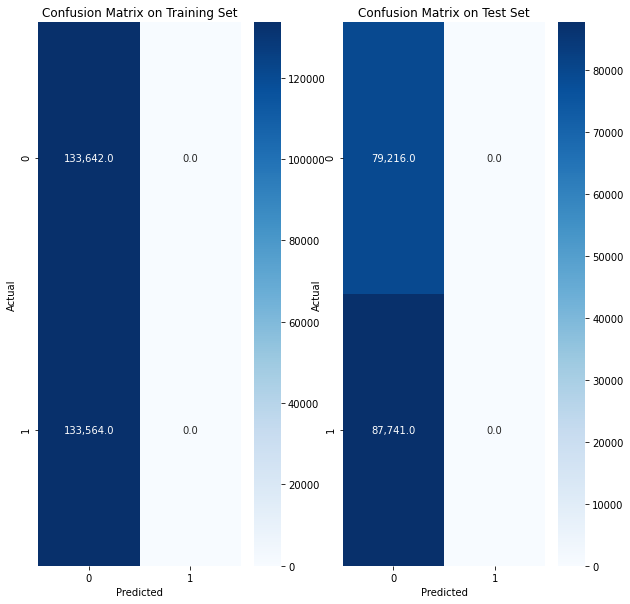

In [0]:
plotConfusionMatrix(mllib_train_results, mllib_test_results)

## Comparison: Native Implementation vs MLLib

In [0]:
comp_df = pd.concat([results_df, mllib_results_df])

In [0]:
print(comp_df.T)

Training (Native) Test (Native) Training (MLLib) \
Area Under ROC 0.555052 0.538238 0.500000 
Area Under PR 0.698822 0.703687 0.499854 
F1 score 0.230749 0.170727 0.000000 
Recall 0.133472 0.094882 0.000000 
Precision 0.850931 0.850966 0.000000 
Accuracy 0.555175 0.515600 0.500146 

 Test (MLLib) 
Area Under ROC 0.500000 
Area Under PR 0.525531 
F1 score 0.000000 
Recall 0.000000 
Precision 0.000000 
Accuracy 0.474469